In [388]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [389]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [390]:
# BYMARKEDER
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")

# KOMMUNEMARKEDER
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_full_l%C3%A6s%C3%B8.csv")

df = df.drop(['Unnamed: 0'], axis=1)

In [440]:
df

,Kommune,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,antal_apo,År,receptgrænse,restriction,logbefolkning,logmarkedsvalue,logindkomst,Navn,yderkom,yder_mono
0,825,52.28,0.37,0.13,158750.32,0.47,0.75,0.92,1793,489477.15,0,2016,302762.97,True,1.79,4.89,1.59,Læsø,1,1
1,825,51.74,0.35,0.14,154652.82,0.47,0.73,0.93,1795,789854.05,0,2014,289205.91,True,1.79,7.90,1.55,Læsø,1,1
2,825,53.05,0.39,0.13,166023.23,0.49,0.76,0.91,1806,556332.47,0,2018,316955.54,True,1.81,5.56,1.66,Læsø,1,1
3,825,52.95,0.38,0.13,165000.49,0.48,0.75,0.91,1807,570316.13,0,2017,309777.99,True,1.81,5.70,1.65,Læsø,1,1
4,825,51.95,0.35,0.14,156009.18,0.47,0.73,0.94,1808,467556.57,0,2013,282656.75,True,1.81,4.68,1.56,Læsø,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,751,37.13,0.14,0.19,184168.34,0.50,0.70,0.84,335684,1977970.26,20,2016,302762.97,True,335.68,19.78,1.84,Aarhus,0,0
327,751,37.14,0.14,0.19,188941.31,0.51,0.71,0.83,340421,1870296.86,22,2017,309777.99,True,340.42,18.70,1.89,Aarhus,0,0
328,751,37.15,0.15,0.18,193949.17,0.51,0.71,0.83,345332,2192706.95,23,2018,316955.54,True,345.33,21.93,1.94,Aarhus,0,0
329,101,35.39,0.10,0.18,213433.78,0.55,0.73,0.75,613288,2031495.79,33,2017,309777.99,True,613.29,20.31,2.13,København,0,0


In [391]:
# df['Befolkning'] betyder at det er på kommuneniveau - er det korrekt?
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, float("inf") , float("inf") , float("inf")]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [392]:
# KOMMUNER
df['logbefolkning'] = df['Befolkning']/1000#df['By_befolkning']/1000

# BYMARKEDER
#df['logbefolkning'] = df['By_befolkning']/1000#


###
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

# Unrestricted markets
df = df[df['restriction']==True]

In [393]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [394]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

In [382]:
def V(df, Ni, alpha=np.ones(5), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([5, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log(), 

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(5)):
    n = np.min([5, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[5]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S


def neg_log_lik(theta=np.ones(18), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 6
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[5] = np.log( Phi(Pi_bar(5)) )
    for i in range(1,5):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(6):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(5):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[5] * (df[market] >= 5))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [443]:
theta0 = np.ones(18) * 0.1
neg_log_lik(df=df, theta=theta0)

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


672.2085251147411

In [444]:
%%time
ba = [-np.inf] * 7
bb = [0] * 10
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 18
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(18) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log


Wall time: 3min 4s


In [463]:
Hfun = nd.Hessian(nll, full_output=True) #out.hess_inv.todense()
# Hfun
hessian_nd, info= Hfun(out['x'])
# hessian_nd

se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
#se = np.sqrt(np.diag((out.hess_inv.todense())))#.shape
#se
results = pd.DataFrame({'parameters':out['x'],'std err':se})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom' ,'alpha_1','alpha_2','alpha_3','alpha_4','alpha_5','gamma_1','gamma_2','gamma_3','gamma_4','gamma_5', 'gamma_6 - Landvalue'] #,'gamma6' 


C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [447]:
results

,parameters,std err
lambda - befolkning,0.85,0.65
beta_1 - d65,0.51,0.40
beta_2 - d17,-0.11,0.23
beta_3 - indkomst,-0.02,0.02
beta_4 - besk,0.12,0.11
beta_5 - Foreigner,-0.10,0.09
beta_6 - yderkom,-0.97,1.35
alpha_1,1.84,1.01
alpha_2,1.74,1.02
alpha_3,0.01,0.03


In [448]:
hat_theta = theta_to_param_dict(out.x)

In [449]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

2.303050106403381
[1.81896586]
2.303050106403381
[0.07565466]
3.5076829678577104
[0.06127101]
3.6156377154907156
[0.03327079]
4.381862788392423
[0.03327079]


In [450]:
S_vals

array([  1.26613157,  30.44161662,  57.24865701, 108.67302246,
       131.70298317])

In [451]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,1.27,30.44,57.25,108.67,131.70


In [452]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']

In [453]:
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,12.02,1.25,1.42,0.97


In [454]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [455]:
SN_S5_ratio

array([20.80399639,  1.7305649 ,  1.38032565,  0.96953581,  1.        ])

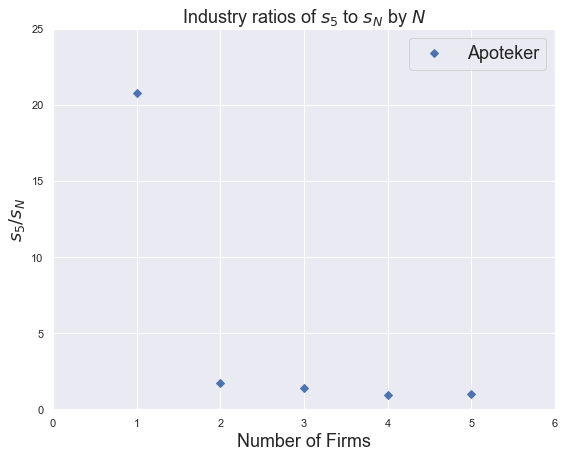

In [457]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0, 25)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)